<a href="https://colab.research.google.com/github/PhilChodrow/PIC16B/blob/master/lectures/tf/tf-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification and Word Embedding

In this set of notes, we'll discuss the problem of *text classification*. Text classification is a common problem in which we aim to classify pieces of text into different categories. These categories might be about:

- **Subject matter**: is this news article about news, fashion, finance?
- **Emotional valence**: is this tweet happy or sad? Excited or calm? This particular class of questions is so important that it has its own name: *sentiment analysis.* 
- **Automated content moderation**: is this Facebook comment a possible instance of abuse or harassment? Is this Reddit thread promoting violence? Is this email spam? 

These are all very different kinds of questions, but many of the same techniques can be used. In these notes, we'll do a simple example of subject matter classification. In future notes, we'll also do some sentiment analysis. 


### Bias in Natural Language Processing

Like all other machine learning algorithms, natural language algorithms naturally inherit the biases of both the data on which they are trained and the choices made by researchers in training the algorithms. A sub-theme of this set of lectures is the need to carefully check our model outputs so that we can understand the impact of each of these. 

#### Optional Review

- [Term-document matrices](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16A/blob/master/content/NLP/NLP_1.ipynb). 
- [Sentiment analysis](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16A/blob/master/content/NLP/NLP_3.ipynb). 

#### Related Resources

- This set of lecture notes is partially based on this [official tutorial](https://www.tensorflow.org/tutorials/keras/text_classification). 

#### Heads Up

To run the code in this notebook, you will actually need to **update TensorFlow**. To do this, open up a terminal and type the following two lines: 

```bash
conda activate PIC16B
pip install tensorflow==2.4
```

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

# requires update to tensorflow 2.4
# >>> conda activate PIC16B
# >>> pip install tensorflow==2.4
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for embedding viz
import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

For this example, we are going to use a data set containing headlines from a large number of different news articles on the website [HuffPost](https://www.huffpost.com/). I retrieved this data [from Kaggle](https://www.kaggle.com/rmisra/news-category-dataset). 

In [ ]:
url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/news/News_Category_Dataset_v2.json"
df  = pd.read_json(url, lines=True)
df  = df[["category", "headline"]]

There are over 200,000 headlines listed here, along with the category in which they appeared on the website. 

In [ ]:
df.head()

,category,headline
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


Our task will be to teach an algorithm to classify headlines by predicting the category based on the text of the headline. 

Training a model on this much text data can require a lot of time, so we are going to simplify the problem a little bit, by reducing the number of categories. Let's take a look at which categories we have: 

In [ ]:
df.groupby("category").size()

category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          2579
dtype: 

Some of these categories are a little odd:

- "Women"? 
- "Weird News"? 
- What's the difference between "Style," "Style & Beauty," and "Taste"? ). 
- "Parenting" vs. "Parents"? 
- Etc?...

Well, there are definitely some questions here! Let's just choose a few categories, and discard the rest: 

In [ ]:
categories = ["STYLE", "SCIENCE", "TECH"]

df = df[df["category"].apply(lambda x: x in categories)]
df.head()

,category,headline
137,TECH,Facebook Accused Of Reading Texts And Accessin...
138,TECH,Self-Driving Uber In Fatal Accident Had 6 Seco...
155,SCIENCE,Scientists Turn To DNA Technology To Search Fo...
272,TECH,Instagram Is Adding A 'Mute' Button For The Sa...
285,SCIENCE,Unusual Asteroid Could Be An Interstellar Gues...


Next, we'll use a `LabelEncoder` to transform the `category` column into integers. 

**Note**: I couldn't find a way that I was satisfied with to do this in TensorFlow, but if you know a smooth way, let me know! 

In [ ]:
le = LabelEncoder()
df["category"] = le.fit_transform(df["category"])
df.head()

,category,headline
137,2,Facebook Accused Of Reading Texts And Accessin...
138,2,Self-Driving Uber In Fatal Accident Had 6 Seco...
155,0,Scientists Turn To DNA Technology To Search Fo...
272,2,Instagram Is Adding A 'Mute' Button For The Sa...
285,0,Unusual Asteroid Could Be An Interstellar Gues...


Later, we'll be able to remember which integers correspond to which classes using the `classes_` attribute of the encoder. 

In [ ]:
le.classes_

array(['SCIENCE', 'STYLE', 'TECH'], dtype=object)

We're left with a much smaller number of rows, which will be much easier to work with. 

#### So Far....

...we have accessed our data, examined the categories available, and taken a subset of the data corresponding to just three categories. 

## TensorFlow Datasets

Next, we are going create a TensorFlow `Dataset` from our data frame. While we often talk colloquially about "data sets", TensorFlow has a special `Dataset` class with a number of convenient capabilities. Use of `Dataset`s is generally optional, but can make it significantly easier to stay organized when writing data pipelines. The `Dataset` class also includes functionality for a wide-variety of data input scenarios, including situations in which the data should be read in chunks-at-a-time from disk. 

The `Dataset` class is useful for all kinds of problems, not just text classification problems. Learn more about it [here](https://www.tensorflow.org/guide/data).

We'll make a dataset with the predictor data (the headline) and target data (the category) separated out. 

In [ ]:
data = tf.data.Dataset.from_tensor_slices((df["headline"], df["category"]))

In [ ]:
for headline, category in data.take(5):
    print(headline)
    print(category)
    print("")

tf.Tensor(b'Facebook Accused Of Reading Texts And Accessing Microphones In Lawsuit', shape=(), dtype=string)
tf.Tensor(2, shape=(), dtype=int64)

tf.Tensor(b'Self-Driving Uber In Fatal Accident Had 6 Seconds To React Before Crash', shape=(), dtype=string)
tf.Tensor(2, shape=(), dtype=int64)

tf.Tensor(b'Scientists Turn To DNA Technology To Search For Loch Ness Monster', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)

tf.Tensor(b"Instagram Is Adding A 'Mute' Button For The Sake Of Your Sanity", shape=(), dtype=string)
tf.Tensor(2, shape=(), dtype=int64)

tf.Tensor(b'Unusual Asteroid Could Be An Interstellar Guest To Our Solar System', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)



Now we'll perform a train-test split. We'll also take out a small validation set. 

In [ ]:
data = data.shuffle(buffer_size = len(data))

In [ ]:
train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

In [ ]:
len(train), len(val), len(test)

(4559, 651, 1304)

#### So far....

...we have created a special TensorFlow `Dataset` and split it into training, validation, and testing sets. 

## Standardization and Vectorization

*Standardization* refers to the act of taking a some text that's "messy" in some way and making it less messy. Common standardizations include: 

- Removing capitals. 
- Removing punctuation. 
- Removing HTML elements or other non-semantic content. 

In this standardization, we convert all text to lowercase and remove punctuation. 

In [ ]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

*Vectorization* refers to the process of representing text as a vector (array, tensor). There are multiple ways to carry out vectorization. For example, forming a *term-document matrix*, as demonstrated in the optional review lecture notes, is one way to form vectors from text. Here, we'll use a different approach: we'll replace each word by its *frequency rank* in the data. For example, the headline

> Poll: Penguins Best Bird

might have representation 

```[708, 1567, 89, 632].```

This means that "poll" is the 708th most common word in the data set, "penguins" is the 1567 most common word in the data set, and so on.  

For technical details on how TensorFlow carries out the vectorization, check [the docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization). Note that we pass the standardization from above as an argument to the vectorization layer.  

In [ ]:
# only the top distinct words will be tracked
max_tokens = 2000

# each headline will be a vector of length 25
sequence_length = 25

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=max_tokens, # only consider this many words
    output_mode='int',
    output_sequence_length=sequence_length) 

We need to *adapt* the vectorization layer to the headlines. In the adaptation process, the vectorization layer learns what words are common in the headlines. 

In [ ]:
headlines = train.map(lambda x, y: x)
vectorize_layer.adapt(headlines)

Now we're ready to vectorize each of the data sets. To do so, we define a helper function that operates on our Datasets. Note that our Dataset consists of a bunch of tuples of the form (headline, category) for each data observation. Our helper function therefore accepts and returns two variables. 

**Note**: because we adapted the vectorization layer to the training data, not the validation or testing data, we aren't "cheating" by propagating information from the validation or testing data prior to the training step. 

In [ ]:
def vectorize_headline(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_headline)
val_vec   = val.map(vectorize_headline)
test_vec  = test.map(vectorize_headline)

Let's take a look at a vectorized piece of text. 

In [ ]:
list(train_vec.take(2))

[(<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
  array([[   6,    1, 1686,  402,   64,    6,  541,  745,    8,    2,    1,
           133,    1,   68,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>),
 (<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
  array([[   1, 1644,  309,   17,  755,  279,  953,   13, 1931,    4, 1159,
            31, 1805,   22,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>)]

#### So far...

...we have finally prepared our data! We have represented each of our headlines as numerical vectors, which are something that TensorFlow is able to understand. 

## Modeling

Phew, that was a lot of data preparation! That's kind of how it is in the world of machine learning: so much of the effort goes into ensuring that your data is correctly formatted and represented. 

Let's now construct a simple model out of some layers. This model is going to have a few new components. 

The most interesting of these, which we are going to come back to, is the `Embedding` layer. Because we're going to come back to it, let's give it a name! 

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 3, name="embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(len(categories))]
)

In [ ]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

Let's go ahead and fit our model. 

In [ ]:
history = model.fit(train_vec, epochs = 20, validation_data = val_vec)

Epoch 1/20
4559/4559 [==============================] - 14s 3ms/step - loss: 1.0909 - accuracy: 0.3951 - val_loss: 1.0051 - val_accuracy: 0.7220
Epoch 2/20
4559/4559 [==============================] - 13s 3ms/step - loss: 0.9665 - accuracy: 0.6472 - val_loss: 0.7934 - val_accuracy: 0.7942
Epoch 3/20
4559/4559 [==============================] - 13s 3ms/step - loss: 0.7892 - accuracy: 0.7189 - val_loss: 0.6264 - val_accuracy: 0.8464
Epoch 4/20
4559/4559 [==============================] - 13s 3ms/step - loss: 0.6454 - accuracy: 0.7636 - val_loss: 0.5049 - val_accuracy: 0.8341
Epoch 5/20
4559/4559 [==============================] - 13s 3ms/step - loss: 0.5557 - accuracy: 0.7875 - val_loss: 0.4028 - val_accuracy: 0.8909
Epoch 6/20
4559/4559 [==============================] - 13s 3ms/step - loss: 0.4819 - accuracy: 0.8055 - val_loss: 0.3942 - val_accuracy: 0.8771
Epoch 7/20
4559/4559 [==============================] - 13s 3ms/step - loss: 0.4571 - accuracy: 0.8180 - val_loss: 0.3464 - val_ac

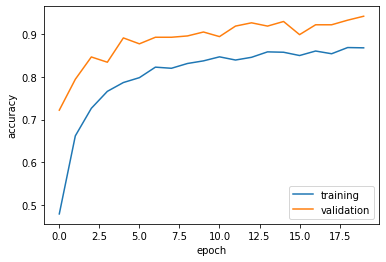

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

At this point, it would be appropriate to be somewhat disturbed -- can it really be correct that the validation accuracy is *higher* than the training accuracy? That doesn't seem right, does it? The reason this occurs is due to those `Dropout` layers in the model. What these layers do is disable ("drop out") a fixed percentage of the units in each layer, *but only during training.* This turns out to be a good way to reduce the risk of overfitting. Because the units are used during validation and testing, but not during training, it can happen that indeed the validation and testing scores can be higher. 

# Predictions on Unseen Data

Let's check our model performance on unseen data. 

In [ ]:
model.evaluate(test_vec)

1304/1304 [==============================] - 2s 2ms/step - loss: 0.2014 - accuracy: 0.9202


[0.20135720074176788, 0.9202454090118408]

Not bad! We're able to correctly classify the category of a given news headline on HuffPost 90% of the time, at least when we are choosing between the three categories that we selected earlier. 

### So far...

...we have trained our model and evaluated it on unseen data, obtaining reasonable results. 

# Embeddings

A *word embedding* refers to a representation of a word in a vector space. Each word is assigned an individual vector. The general aim of a word embedding is to create a representation such that words with related meanings are close to each other in a vector space, while words with different meanings are farther apart. One usually hopes for the *directions* connecting words to be meaningful as well. Here's a nice diagram illustrating some of the general concepts: 

![](https://miro.medium.com/max/1838/1*OEmWDt4eztOcm5pr2QbxfA.png)

*Image credit: [Towards Data Science](https://towardsdatascience.com/creating-word-embeddings-coding-the-word2vec-algorithm-in-python-using-deep-learning-b337d0ba17a8)*

Word embeddings are often produced as intermediate stages in many machine learning algorithms. In fact, we already made one -- it's the `Embedding` layer at the base of our model. Let's take a look at the embedding layer to see how our own model represents words in a vector space. 

We chose to create a 3-dimensional embedding when constructing our model. This is fine for today, but state-of-the-art embeddings will typically have a much higher number of dimensions.  For example, the [Embedding Projector demo](http://projector.tensorflow.org/) supplied by TensorFlow uses a default dimension of 200. 

In [ ]:
weights = model.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

In [ ]:
weights

array([[-0.00346668, -0.02705806,  0.03386084],
       [-0.07210445,  0.02858407,  0.07078321],
       [-0.14725678,  0.22123599, -0.07358611],
       ...,
       [ 0.6221517 , -0.29164547, -0.00860545],
       [-0.3527216 , -0.5142729 ,  0.59269196],
       [ 0.15884909, -0.43469426,  0.301601  ]], dtype=float32)

The collection of weights is 3-dimensional. For plotting in 2 dimensions, we have several choices for how to reduce the data to a 2d representation. A very simple and standard approach is our friend, principal component analysis (PCA). 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

Now we'll make a data frame from our results: 

In [ ]:
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})
embedding_df

,word,x0,x1
0,,-0.074472,0.192914
1,[UNK],-0.087867,0.115070
2,the,-0.325935,0.034162
3,to,-0.338305,0.414869
4,of,0.171812,0.092930
...,...,...,...
1995,students,0.162748,0.189020
1996,strong,0.251267,0.151713
1997,strategy,0.080024,0.845169
1998,stingray,0.667311,-0.155476


Ready to plot! Note that the embedding appear to be "stretched out" in three directions, with one direction corresponding to each of the three categories (tech, style, science). 

In [ ]:
import plotly.express as px 
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 2,
                 hover_name = "word")

fig.show()

Cool, we made a word embedding! This embedding seems to have learned some reasonable associations. For example, we see that words like "Mars", "NASA", and "space" are relatively close to each other. So are "Facebook", "Google", and "Apple", as well as "fashion", "dress", and "style."

## Bias in Language Models

Whenever we create a machine learning model that might conceivably have impact on the thoughts or actions of human beings, we have a responsibility to understand the limitations and biases of that model. Biases can enter into machine learning models through several routes, including the data used as well as choices made by the modeler along the way. For example, in our case: 

1. **Data**: we used data from a popular news source. 
2. **Modeler choice**: we only used data corresponding to a certain subset of labels. 

With these considerations in mind, let's see what kinds of words our model associates with female and male genders. 

In [ ]:
feminine = ["she", "her", "woman"]
masculine = ["he", "him", "man"]

highlight_1 = ["strong", "powerful", "smart",     "thinking"]
highlight_2 = ["hot",    "sexy",     "beautiful", "shopping"]

def gender_mapper(x):
    if x in feminine:
        return 1
    elif x in masculine:
        return 4
    elif x in highlight_1:
        return 3
    elif x in highlight_2:
        return 2
    else:
        return 0

embedding_df["highlight"] = embedding_df["word"].apply(gender_mapper)
embedding_df["size"]      = np.array(1.0 + 50*(embedding_df["highlight"] > 0))

In [ ]:
import plotly.express as px 

fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 color = "highlight",
                 size = list(embedding_df["size"]),
                 size_max = 10,
                 hover_name = "word")

fig.show()

Our text classification model's word embedding is unambiguously sexist. 

- Words like "hot", "sexy", and "shopping" are more closely located to feminine words like "she", "her", and "woman".
- Words like "strong", "smart", and "thinking" are more closely located to masculine words like "he", "him", and "man". 

Where did these biases come from? 

- The primary source is the data itself: HuffPost headlines in certain categories can be highly gendered, and the "Style" category is an example of this. 
- A secondary source is the choices that I made as a modeler. In particular, I intentionally chose categories that would emphasize biases in the data and make them easy to visualize. 

While I could have made different choices and obtained different results, this episode highlights a fundamental set of questions usually underexamined in contemporary machine learning: 

- What biases are built into my data source? 
- How do my choices about which data to use influence the biases present in my model? 

For more on the topic of bias in language models, you may wish to read the now-infamous paper by Emily Bender, Angelina McMillan-Major, Timnt Gebru, and "Shmargret Shmitchell" (Margret Mitchell), "[On the Dangers of Stochastic Parrots](https://faculty.washington.edu/ebender/papers/Stochastic_Parrots.pdf)." This is the paper that ultimately led to the firing of the final two authors by Google in late 2020 and early 2021. 